In [1]:
# 检查GPU环境
!nvidia-smi

Wed Aug  9 14:30:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# 安装依赖python包
!pip install denoising_diffusion_pytorch -qq
!pip install datasets -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 11.0 MB/s eta 0:00:00


In [3]:
# 数据集下载
from PIL import Image
from io import BytesIO
from datasets import load_dataset
import os
from tqdm import tqdm

dataset = load_dataset("nelorth/oxford-flowers")

# 创建一个用于保存图片的文件夹
images_dir = "./oxford-datasets/raw-images"
os.makedirs(images_dir, exist_ok=True)

# 遍历所有图片并保存，针对oxford-flowers，整个过程要持续15分钟左右
for split in dataset.keys():
    for index, item in enumerate(tqdm(dataset[split])):
        image = item['image']
        image.save(os.path.join(images_dir, f"{split}_image_{index}.png"))

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/7169 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1020 [00:00<?, ? examples/s]

100%|██████████| 1020/1020 [02:13<00:00,  7.66it/s]


In [4]:
# 模型训练
import torch
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer

model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8)
).cuda()

diffusion = GaussianDiffusion(
    model,
    image_size = 128,
    timesteps = 1000   # 加噪总步数
).cuda()

trainer = Trainer(
    diffusion,
    './oxford-datasets/raw-images',
    train_batch_size = 16,
    train_lr = 2e-5,
    train_num_steps = 20000,          # 总共训练20000步
    gradient_accumulate_every = 2,    # 梯度累积步数
    ema_decay = 0.995,                # 指数滑动平均decay参数
    amp = True,                       # 使用混合精度训练加速
    calculate_fid = False,            # 我们关闭FID评测指标计算（比较耗时）。FID用于评测生成质量。
    save_and_sample_every = 2000      # 每隔2000步保存一次模型
)

trainer.train()

  0%|          | 0/20000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [7]:
# 你可以等待上面的模型训练完成后，查看生成结果

from glob import glob

result_images = glob(r"./results/*.png")
print(result_images)

['./results/sample-1.png']


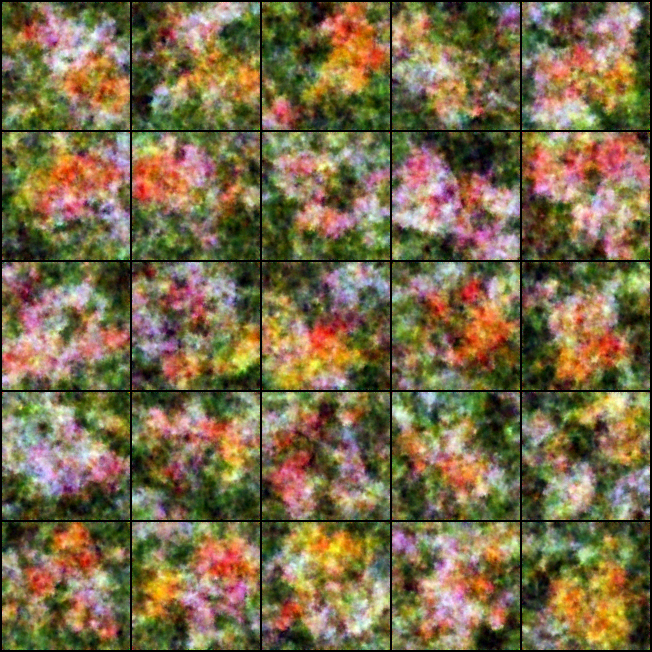

In [9]:
# 可视化图像看看
from PIL import Image

img = Image.open("./results/sample-1.png")
img